# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover? 

### 🧐 Findings Overview:  

- 💻 The IT department has the highest percentage employee turnover (30.9%)
- 🔢 The finance department has the lowest percentage turnover (26.9%).
- 🕵🏽 Average monthly hours, satisifaction and review are the top three features for predicting employee turnover
- 🐱‍👓 Those who leave the company can be characterised as disatisified (satisfaction score), high achievers (review score), who work long hours (avg monthly hours). 
- 💡 From the company's perspective, it would be advisable to reduce or set a cap on average monthly hours to below 185 hours. 

<img src = './img/typing.gif' width="750" align="center">


In [1]:
# importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
from sklearn.cluster import KMeans
from sklearn import preprocessing
import shap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as mp_imb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV



In [56]:
shap.__version__

'0.40.0'

In [2]:
# reading the data
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [3]:
# Question 1: Which department has the highest employee turnover? Which one has the lowest?

In [4]:
total_department_employees = df.groupby(['department'])['left'].size().to_frame('total employees')
total_department_employees

,total employees
department,
IT,356
admin,423
engineering,1516
finance,402
logistics,360
marketing,802
operations,1522
retail,1541
sales,1883


In [5]:
leavers = df[df['left']=='yes']
leavers

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
386,sales,0,0.700577,4,medium,5.0,0.484936,0,180.787350,yes
785,sales,0,0.738060,4,medium,5.0,0.534547,0,179.534464,yes
1078,sales,0,0.600301,3,low,6.0,0.657108,0,182.426505,yes
1155,operations,0,0.722790,3,medium,6.0,0.472769,0,181.921952,yes
1190,support,0,0.679845,3,medium,4.0,0.543203,0,177.469579,yes
...,...,...,...,...,...,...,...,...,...,...
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes


In [6]:
leavers_per_dep = leavers.groupby('department')['left'].count()
leavers_per_dep

department
IT             110
admin          119
engineering    437
finance        108
logistics      111
marketing      243
operations     436
retail         471
sales          537
support        212
Name: left, dtype: int64

In [7]:
df1 = pd.concat([total_department_employees,leavers_per_dep],axis=1)
df1

,total employees,left
department,,
IT,356,110
admin,423,119
engineering,1516,437
finance,402,108
logistics,360,111
marketing,802,243
operations,1522,436
retail,1541,471
sales,1883,537


In [8]:
# calculating turnover rate as a percentage of total employees per department
percentage_turnover_per_dep = round(df1['left']/df1['total employees']*100,1)
percentage_turnover_per_dep.sort_values(ascending=False)

department
IT             30.9
logistics      30.8
retail         30.6
marketing      30.3
support        28.8
engineering    28.8
operations     28.6
sales          28.5
admin          28.1
finance        26.9
dtype: float64

<AxesSubplot:title={'center':'Department wise turnover rate'}, xlabel='Department', ylabel='% turnover'>

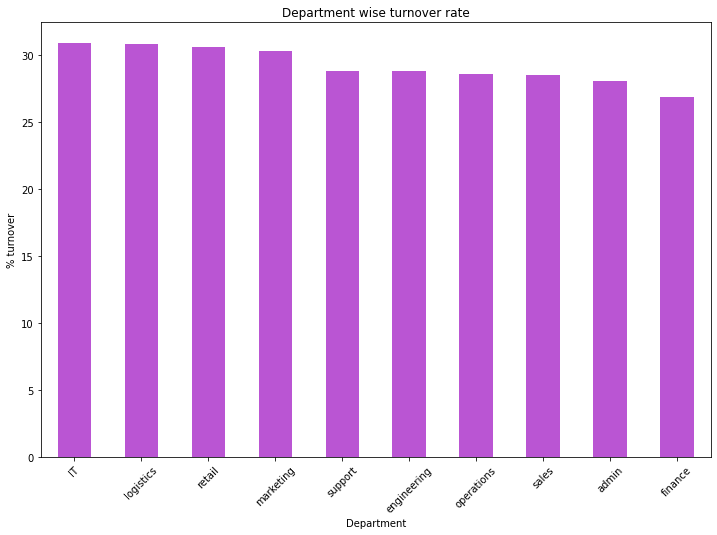

In [9]:
percentage_turnover_per_dep.sort_values(ascending=False).plot.bar('department','turnover rate',title = "Department wise turnover rate", ylabel = '% turnover', xlabel = 'Department', legend = False ,figsize=(12,8), rot = 45, color = 'mediumorchid')


The IT department has the largest employee turnover rate, while the finance department has the lowest level of employee turnover

In [10]:
# Exploratory Analysis in prep for machine learning 

In [11]:
df.tail()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes
9539,finance,0,0.626373,3,low,7.0,0.706455,1,185.920934,yes


In [12]:
df.shape

(9540, 10)

In [13]:
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


In [14]:
df.columns

Index(['department', 'promoted', 'review', 'projects', 'salary', 'tenure',
       'satisfaction', 'bonus', 'avg_hrs_month', 'left'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [16]:
df.isnull().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

In [17]:
# No null values

In [18]:
left = df.groupby('left')
left.mean()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,
no,0.034340,0.635164,3.279455,6.546625,0.505634,0.215068,184.637605
yes,0.020474,0.692262,3.263649,6.579382,0.502244,0.204741,184.719730


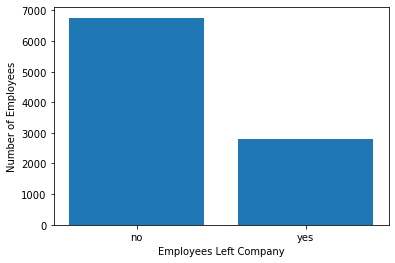

In [19]:
left_count=df.groupby('left').count()
plt.bar(left_count.index.values, left_count['satisfaction'])
plt.xlabel('Employees Left Company')
plt.ylabel('Number of Employees')
plt.show()

In [20]:
Counter(df['left'])

Counter({'no': 6756, 'yes': 2784})

In [21]:
# imbalanced classes!

In [22]:
2784/len(df['left'])

0.2918238993710692

In [23]:
# 29% of employees have left the company, which is quite a high turnover rate

In [24]:
# looking at correlations
cormat = df.corr()
round(cormat,2)

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
promoted,1.00,0.00,0.01,0.00,-0.01,0.0,-0.00
review,0.00,1.00,0.00,-0.18,-0.35,-0.0,-0.20
projects,0.01,0.00,1.00,0.02,0.00,0.0,0.02
tenure,0.00,-0.18,0.02,1.00,-0.15,-0.0,0.98
satisfaction,-0.01,-0.35,0.00,-0.15,1.00,0.0,-0.14
bonus,0.00,-0.00,0.00,-0.00,0.00,1.0,-0.00
avg_hrs_month,-0.00,-0.20,0.02,0.98,-0.14,-0.0,1.00


<AxesSubplot:>

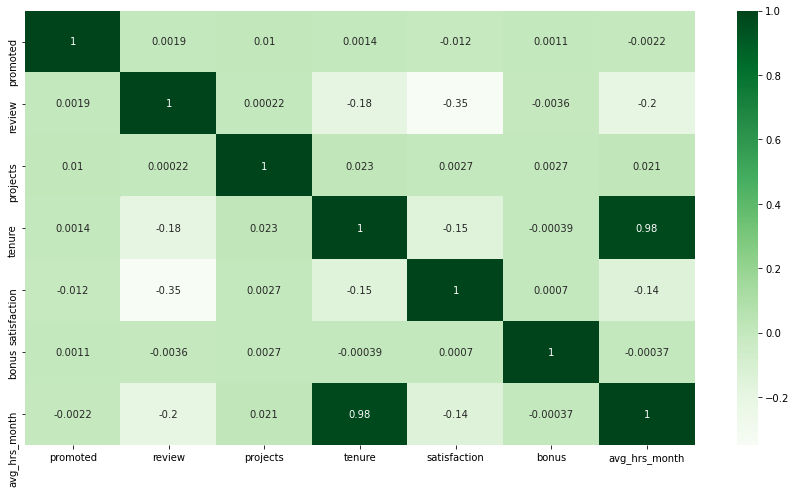

In [25]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot = True, cmap="Greens")

Text(0, 0.5, 'tenure')

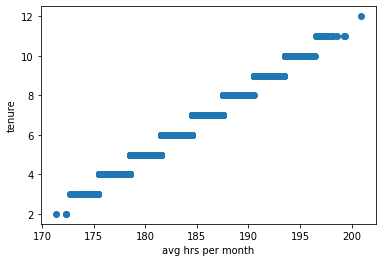

In [26]:
# People with higher tenure at the company work higher number of hours, direct positive linear relationship
plt.scatter(df.avg_hrs_month, df.tenure)
plt.xlabel("avg hrs per month")
plt.ylabel("tenure")

Negative relationship between review and satsifaction-
Shown with regression plot

<AxesSubplot:xlabel='review', ylabel='satisfaction'>

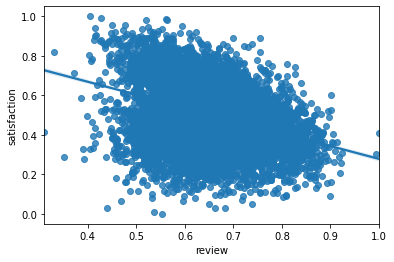

In [27]:
sns.regplot(data=df,x='review',y='satisfaction')

Text(0, 0.5, 'Frequency')

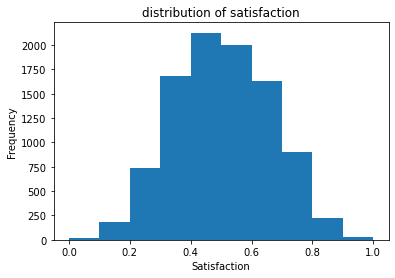

In [28]:
# Distribution plots of continuous variables
# 1) Satisfaction

fig, ax = plt.subplots()
ax.hist(df['satisfaction'])
ax.set_title('distribution of satisfaction')
ax.set_xlabel('Satisfaction')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

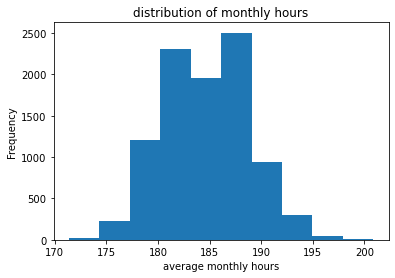

In [29]:
# Average monthly hours
fig, ax = plt.subplots()
ax.hist(df['avg_hrs_month'])
ax.set_title('distribution of monthly hours')
ax.set_xlabel('average monthly hours')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

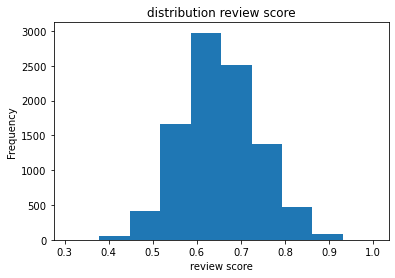

In [30]:
# Review store 
fig, ax = plt.subplots()
ax.hist(df['review'])
ax.set_title('distribution review score')
ax.set_xlabel('review score')
ax.set_ylabel('Frequency')

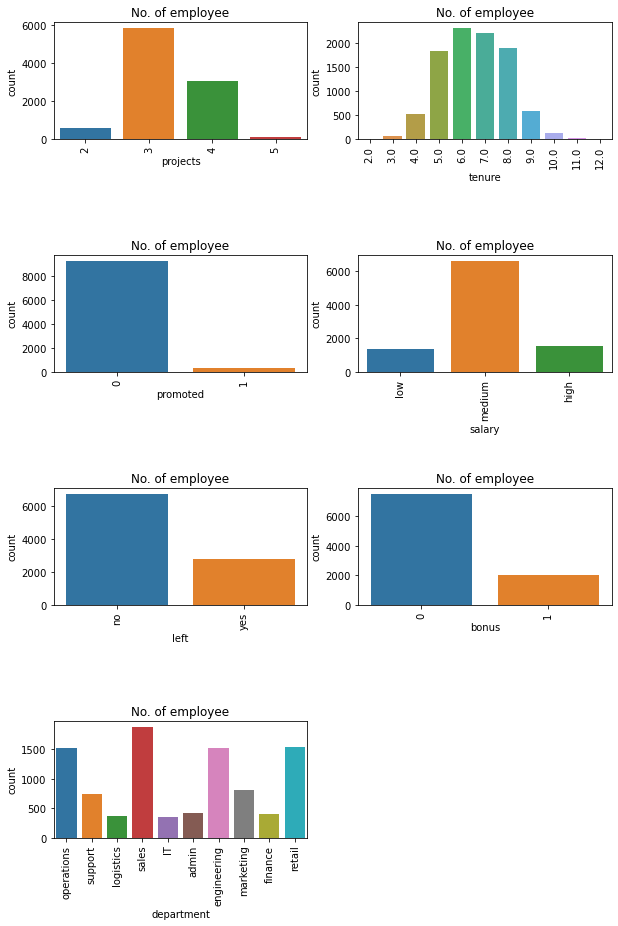

In [31]:
#subplots of discrete variables
features=['projects','tenure','promoted','salary','left','bonus','department']
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df)
    plt.xticks(rotation=90)
    plt.title("No. of employee")

We see here that this company rarely offers promotions

Text(0.5, 1.0, 'employee promotion average per department')

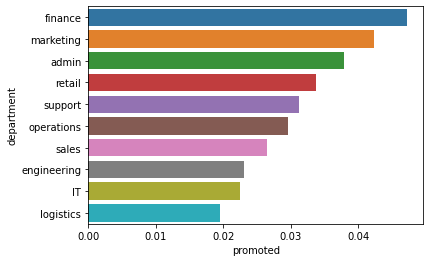

In [32]:
# let's see promoted plot per department

promoted = df.groupby('department',as_index=False)[['promoted']].mean().sort_values('promoted',ascending=False)
sns.barplot(data=promoted,y='department',x='promoted')
ax.set_title('employee promotion average per department')

💡 Finance department has the highest mean promotion level across all departments, while IT and logistics have the lowest promotion level. This is interesting as the finance department has the lowest percentaage employee turnover, while IT and logistics department have the highest employee turnover. 

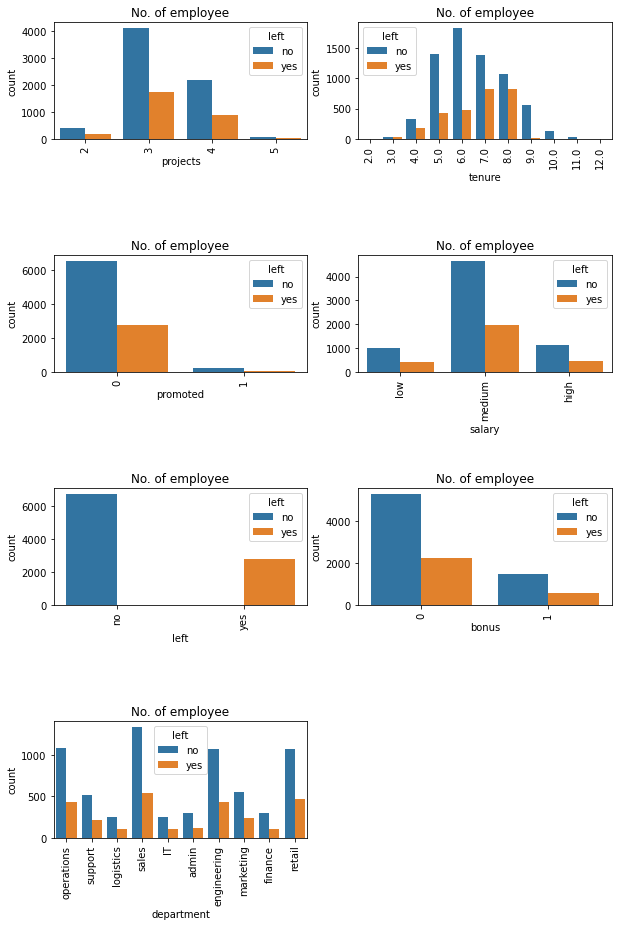

In [33]:
#plotting discrete variables and setting 'left' as hue

fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

Significant proportion of employees leave after 7-8 years tenure, while very few employees leave after 9 years in the company

Let's look at the features in more depth with the help of machine learning

Feature engineering and creating ML model

In [34]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting department,salary features to numerical values
df['salary']=le.fit_transform(df['salary'])
df['department']=le.fit_transform(df['department'])
# converting left label to numerical values
df['left']=le.fit_transform(df['left'])

In [35]:
#setting features and labels
X = df[['promoted', 'review', 'projects','salary','tenure',
       'satisfaction', 'bonus', 'avg_hrs_month','department']]
y = df['left']

In [36]:
# transform the dataset with SMOTE oversampling

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [37]:
# checking classes after oversampling
# 0=remained, 1=left
counter=(Counter(y))
counter

Counter({0: 6756, 1: 6756})

In [38]:
#splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 


In [39]:
# creating random forest classifier



In [50]:
#creating and fitting random forest classifier with default parameters
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [96]:
print(classification_report(y_test, clf.predict(X_test)))
print("Random Forest score for training set:", round(clf.score(X_train, y_train),5))
print('Random Forest accuracy with all features on testing data:', accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1987
           1       0.88      0.88      0.88      2067

    accuracy                           0.88      4054
   macro avg       0.88      0.88      0.88      4054
weighted avg       0.88      0.88      0.88      4054

Random Forest score for training set: 1.0
Random Forest accuracy with all features on testing data: 0.8495313270843611


Fairly even precision and recall, which means that our model is accurate for predicting both employees that have left and remained

Overfitting on training set with 1 accuracy score(indicating high variance), try to adjust with cross validation later
Testing data accuracy of ~ 0.88 gives some confidence

In [42]:
# plot confusion matrix
rf_cm = confusion_matrix(y_test,clf.predict(X_test))

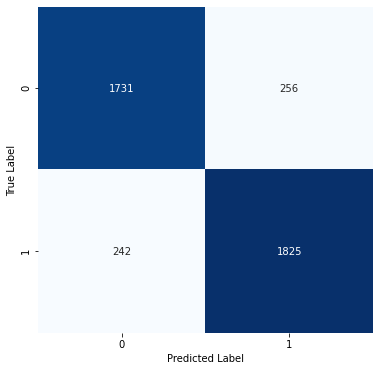

In [43]:
plt.figure(figsize=(6,6))
sns.heatmap(rf_cm, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# calculating feature importance
feature_importance = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_importance


avg_hrs_month    0.274720
satisfaction     0.267067
review           0.256811
tenure           0.101381
department       0.047149
projects         0.019446
salary           0.017682
bonus            0.011163
promoted         0.004582
dtype: float64

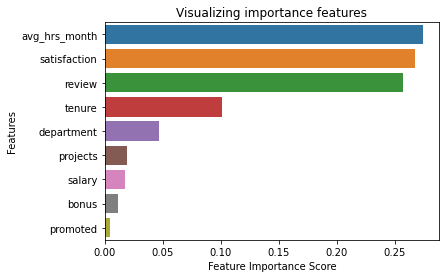

In [45]:
#Plotting feature importance

sns.barplot(x=feature_importance,y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing importance features')
plt.show()



The most important features are avg_hrs_month, review and satisfaction

In [47]:
print('Parameters currently in use:\n')
pprint(clf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [48]:
# hyperparameter tuning using gridsearchcv---SLOW to run

clf = RandomForestClassifier(random_state=1)


param_grid = {
    'n_estimators':[50,75,100,125,150],
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[1,2,3,4],
    'max_depth':[2,4,6,8]}

grid_obj = GridSearchCV(
    clf,
    return_train_score=True,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5)

grid_fit = grid_obj.fit(X_train,y_train)
grbt_opt = grid_fit.best_estimator_

print("="*20)
print("best params:" + str(grid_obj.best_estimator_))
print("best params:" + str(grid_obj.best_params_))
print("best score:",grid_obj.best_score_)
print("="*20)

best params:RandomForestClassifier(max_depth=8, n_estimators=50, random_state=1)
best params:{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best score: 0.8598005127213248


Grid search with 5 fold cross validation gives a best accuracy score of 0.859

50 trees in the forest--> fairly efficient training process 
Each tree has a depth of 8, as opposed to max_depth None, this could be why the model without hyperparamter tuning was overfitting on the training data, by capturing too much information about the data. 
Default values for min_sample leaf and min_samples split remain unchanged

In [75]:
# fitting best random forest classifier

best_rf = RandomForestClassifier(random_state=1,max_depth=8,n_estimators=50,min_samples_split=2,min_samples_leaf=1)
best_rf.fit(X_train,y_train)
y_pred = best_rf.predict(X_test)

In [103]:
print(classification_report(y_test, best_rf.predict(X_test)))
print("Best Random Forest score for training set:", round(best_rf.score(X_train, y_train),5))
print('Best Random Forest accuracy on testing data:', round(accuracy_score(y_test,y_pred),5))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1987
           1       0.85      0.86      0.85      2067

    accuracy                           0.85      4054
   macro avg       0.85      0.85      0.85      4054
weighted avg       0.85      0.85      0.85      4054

Best Random Forest score for training set: 0.8819
Best Random Forest accuracy on testing data: 0.84953


Giving the model a max depth of 8 reduced the level of overfitting on training data

Findings from machine learning models
1) Top 3 variables for predicting employee turnover are satisfaction, average monthly hours and review score

2) Random Forest Classifier offers good accuracy results after hyperparameter tuning,max_depth important 


Ploting top features for leavers and remainers for comparison (for making recommendations)

In [69]:
leavers = df[df['left']==1]

In [70]:
remainers = df[df['left']==0]

Text(0.5, 1.0, 'Employee Satisfaction Distribution - Leaver V.S. No Remainer')

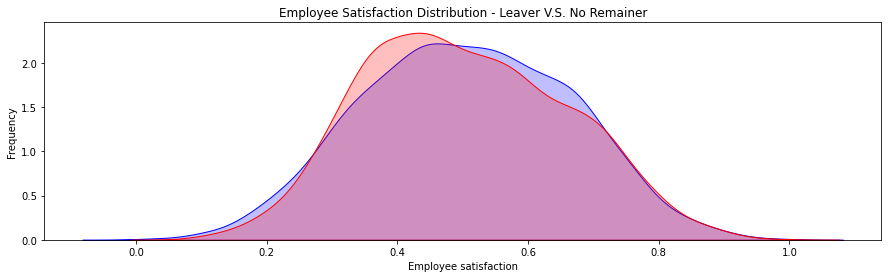

In [71]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data=remainers,x='satisfaction' , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(data=leavers,x='satisfaction', color='r',shade=True, label='turnover')
ax.set(xlabel='Employee satisfaction', ylabel='Frequency')
plt.title('Employee Satisfaction Distribution - Leaver V.S. No Remainer')

The histgrams show that leavers have slightly lower satisfaction compared to remainers

Text(0.5, 1.0, 'Employee Review Distribution - Turnover V.S. No Turnover')

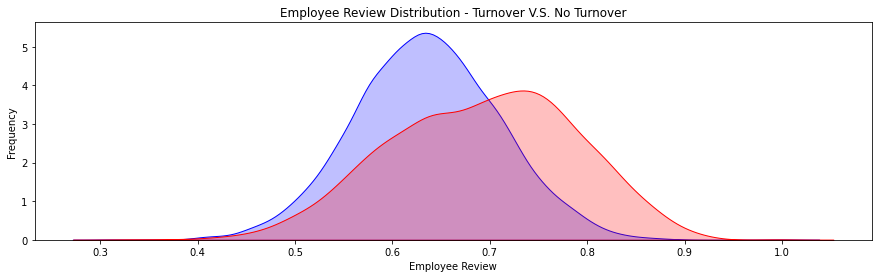

In [72]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data=remainers,x='review' , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(data=leavers,x='review', color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Review', ylabel='Frequency')
plt.title('Employee Review Distribution - Turnover V.S. No Turnover')

Leavers have higher review scores compared to remainers

Text(0.5, 1.0, 'Employee Average Monthly Hours Distribution - Turnover V.S. No Turnover')

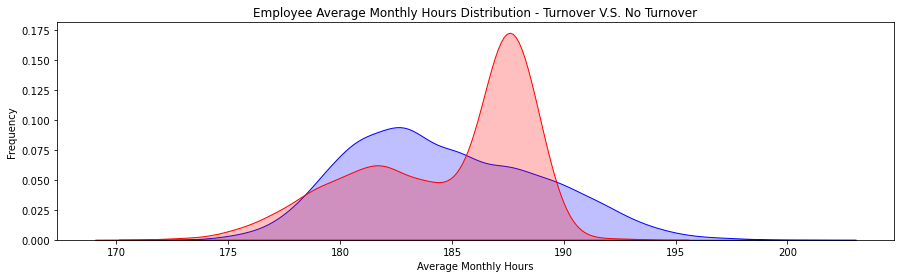

In [73]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data=remainers,x='avg_hrs_month' , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(data=leavers,x='avg_hrs_month', color='r',shade=True, label='turnover')
ax.set(xlabel='Average Monthly Hours', ylabel='Frequency')
plt.title('Employee Average Monthly Hours Distribution - Turnover V.S. No Turnover')

The distribution of average monthly hours for leavers is more uneven compared to remainers. 

Leavers work more than 185 hours per month, while most remainers work between 180-185 hours per month. Burnout could be an important reason why employees are leaving. 

We can conclude that leavers work longer hours, have lower satisfaction scored and have higher review scores. 

Recommendations

1). Based on closer analysis of the top three factors affecting employee turnover, from the company's perspective, it would be advisable to cap average monthly hours to below 185 hours. As we see a high level of employees leaving the company past the 185 average monthly hours point

2). In our exploratory analysis, we saw a negative correlation between satisifaction and review score, where the employees with high review scores tend to have lower level of satifaction. We can therefore summise that leavers are generally high achievers (high review scores), who work long hours but are not satisified with their role.

3). We see from EDA that finance department has lowest percentage of employee turnover, and the highest rate of promotions. While IT and logistics departments have highest percentage of employee turnover and the lowest rate of promotions. It is looking into offering more frequent promotions, as promotions are low across the company as a whole. It is also worth observing the finance department's other practices to see why they have the lowest percentage of employee turnover.---Logically, if you are a high performing (high review), hard working (long average monthly hours), but you are not getting promotional opportunities, this would negatively affect your satisfaction level, and you are more likely to consider opportunities elsewhere. 



